In [87]:
import json

# Load the dataset
with open('data.json', 'r', encoding='utf-8') as f:
    games = json.load(f)

# Now `games` is a list of all your game entries
print(f"Loaded {len(games)} games!")

# Example: access the first game
first_game = games[1]
white_elo, black_elo, outcome, moves, evals = first_game



Loaded 1800 games!


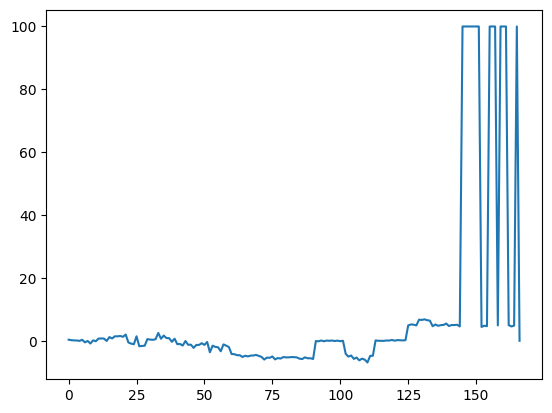

In [51]:
import matplotlib.pyplot as plt

plt.plot(evals)

In [88]:
for game in games:
    game[4] = [-20 if eval < -20 else 20 if eval > 20 else eval for eval in game[4]]

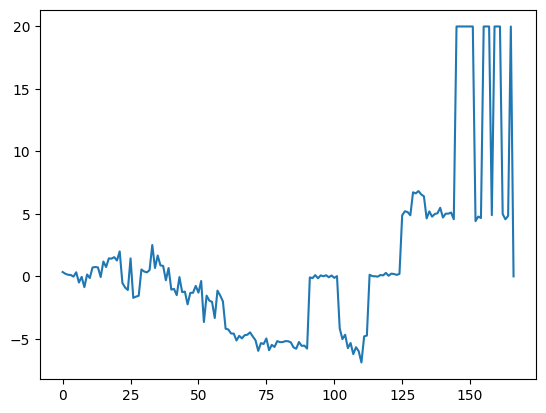

In [53]:
# Example: access the first game
first_game = games[1]
white_elo, black_elo, outcome, moves, evals = first_game
plt.plot(evals)

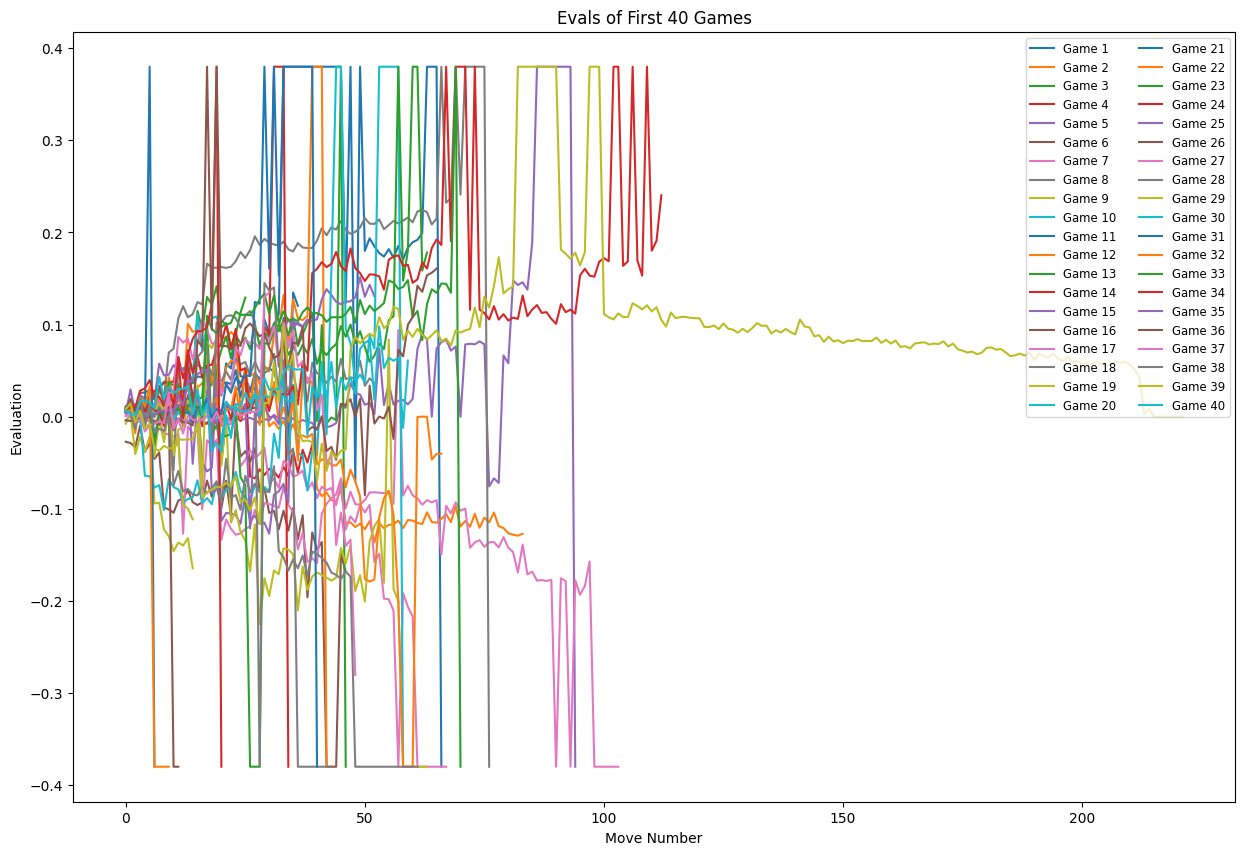

In [89]:
import numpy as np

plt.figure(figsize=(15, 10))

for i, game in enumerate(games[40:80]):
    plt.plot(np.tanh(np.asarray(game[4])/50), label=f'Game {i+1}')

plt.title('Evals of First 40 Games')
plt.xlabel('Move Number')
plt.ylabel('Evaluation')
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.show()

El principal problema es que las partidas duran distinto, vamos a ver varias posibilidades:
1. Reescalar a una escala común: 
    - Pros: 
        - se mantiene posibilidad de patrones opening-mid game-end game
    - Cons: 
        - se pierde posibilidad de estudiar duración de partidas y ganadores
        - es posible que en muchos casos no se llegue al end game (habría que ver el número de piezas)
        - muchas partidas tendrán muy poca información y serán extendidas
2. Fijar un número de movimientos: alargar las partidas que no lleguen, y truncar las que se pasen.
   Podríamos por ejemplo poner la evaluación de los movimientos faltantes a +-10 o 0 dependiendo del resultado de la partida.
    - Pros: 
        - misma escala permite ver patrones como duración de partidas
        - conocimiento del resultado en muchas
    - Cons: 
        - si el número fijado es bajo, perderíamos todas las partidas de duración mayor que la indicada -> reduce la aplicabilidad
          del análisis a esas partidas largas.
        - si el número fijado es alto, la mayor parte de la información será basura (valor constante)
3. Fijar un número mínimo de movimientos y truncar todas las partidas con más:
    - Pros:
        - misma escala
    - Cons:
        - se pierden muchas partidas

Vamos a probar la fijación de un número de movimientos

In [90]:
for game in games:
    evals = game[4]
    outcome = game[2]
    
    # Determinar el valor a añadir según el resultado de la partida
    if outcome == 'white':
        fill_value = 20
    elif outcome == 'black':
        fill_value = -20
    else:  # empate
        fill_value = 0

    if len(evals) > 100:
        # Truncar a los primeros 90 y añadir los últimos 10 valores
        evals = evals[:100]
    elif len(evals) <= 100:
        # Añadir valores hasta alcanzar longitud 100
        evals = evals + [fill_value] * (100 - len(evals))
    
    # Actualizar las evals en el juego
    game[4] = evals

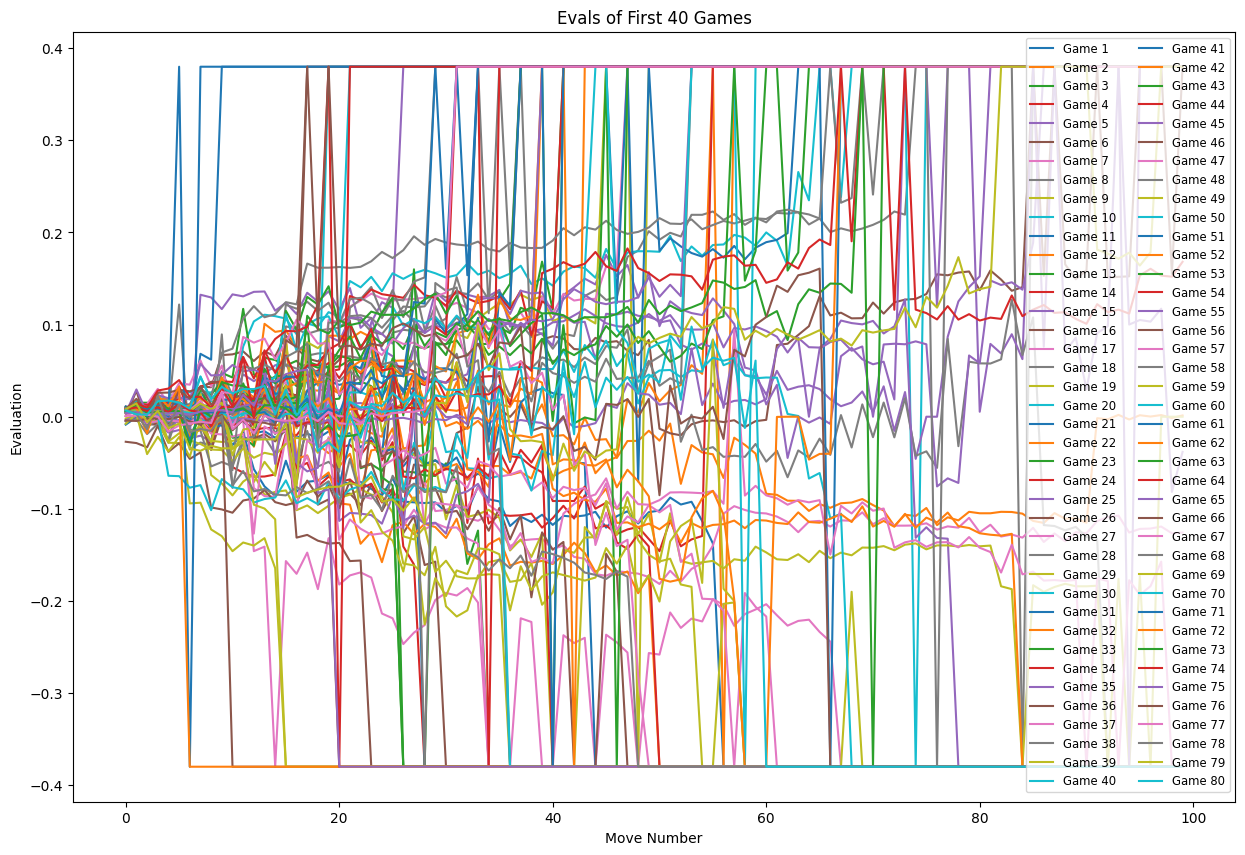

In [91]:
plt.figure(figsize=(15, 10))

for i, game in enumerate(games[0:80]):
    plt.plot(np.tanh(np.asarray(game[4])/50), label=f'Game {i+1}')

plt.title('Evals of First 40 Games')
plt.xlabel('Move Number')
plt.ylabel('Evaluation')
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.show()

In [92]:
for game in games:
    if len(game[4]) != 100:
        print(f"Game with evals != 100: {game[0]}")
        print(f"Length: {len(game[4])}")
        

In [93]:
X = np.asarray([game[4] for game in games])
white_elos = [game[0] for game in games]
black_elos = [game[1] for game in games]
y =  np.asarray([(white + black) / 2 for white, black in zip(white_elos, black_elos)])

In [94]:
import skfda

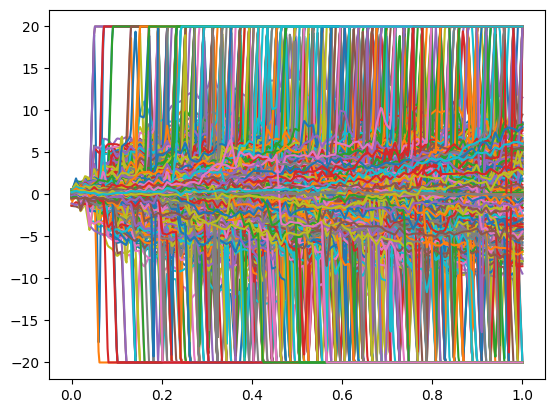

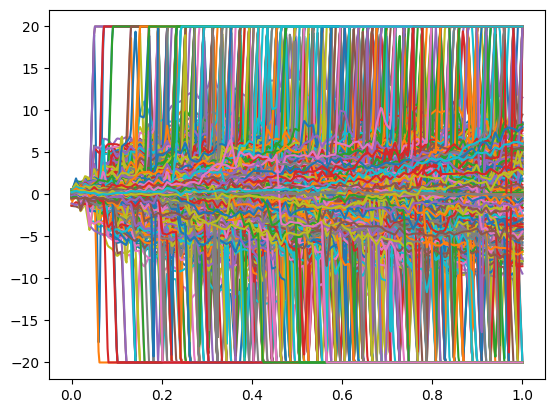

In [95]:
X = skfda.FDataGrid(data_matrix=X, grid_points=np.linspace(0, 1, 100), domain_range=(0, 1))
X.plot()

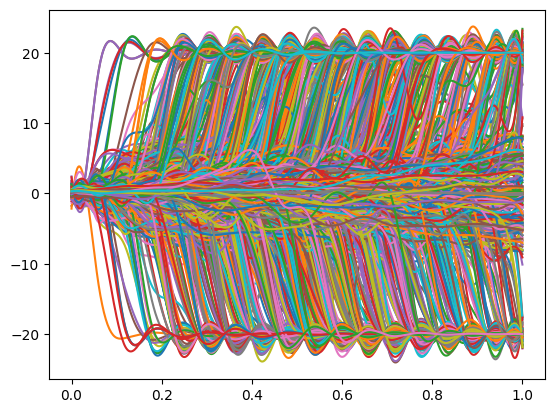

In [96]:
basis = skfda.representation.basis.BSplineBasis(n_basis=20, order=4)
X.to_basis(basis).plot()
plt.show()

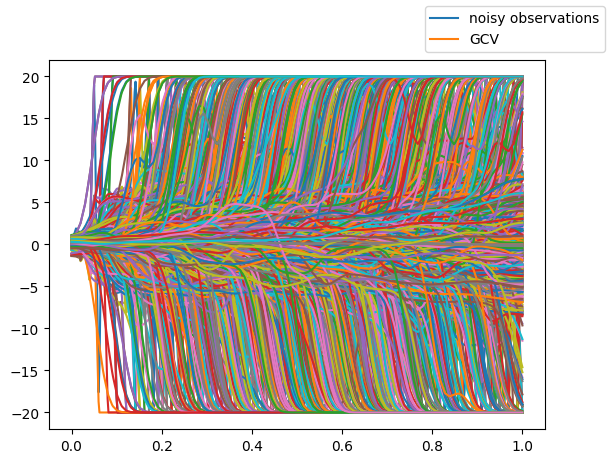

In [97]:
from skfda.preprocessing.smoothing.validation import SmoothingParameterSearch
from skfda.preprocessing.smoothing.validation import akaike_information_criterion, LinearSmootherGeneralizedCVScorer
from skfda.misc.hat_matrix import NadarayaWatsonHatMatrix
from skfda.preprocessing.smoothing import KernelSmoother


# Defining grid search
bandwidth = np.linspace(0.01, 1, 100)


# Nadaraya-Watson kernel smoother
nw = SmoothingParameterSearch(
    KernelSmoother(kernel_estimator=NadarayaWatsonHatMatrix()),
    bandwidth,
    scoring=LinearSmootherGeneralizedCVScorer(penalization_function=lambda t:1),
    param_name='kernel_estimator__bandwidth'
)

# Fit and transform must be done separately since SmoothingParameterSearch
# object do not have fit_transform method
nw.fit(X)
x_opt = nw.transform(X)


fig = X.plot()
x_opt.plot(fig=fig)
fig.legend(
    [
        'noisy observations',
        'GCV',
    ]    
)

plt.show()

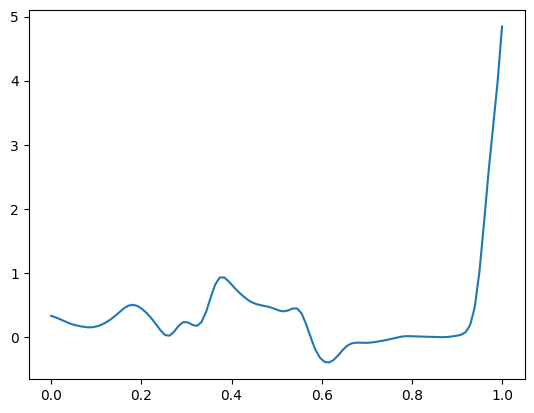

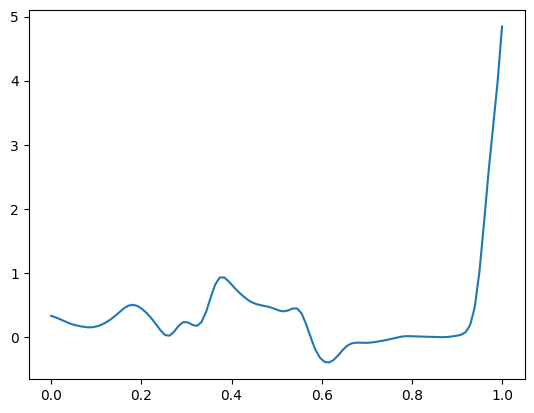

In [106]:
x_opt[1203].plot()

In [3]:
white_elos = [game[0] for game in games]
black_elos = [game[1] for game in games]

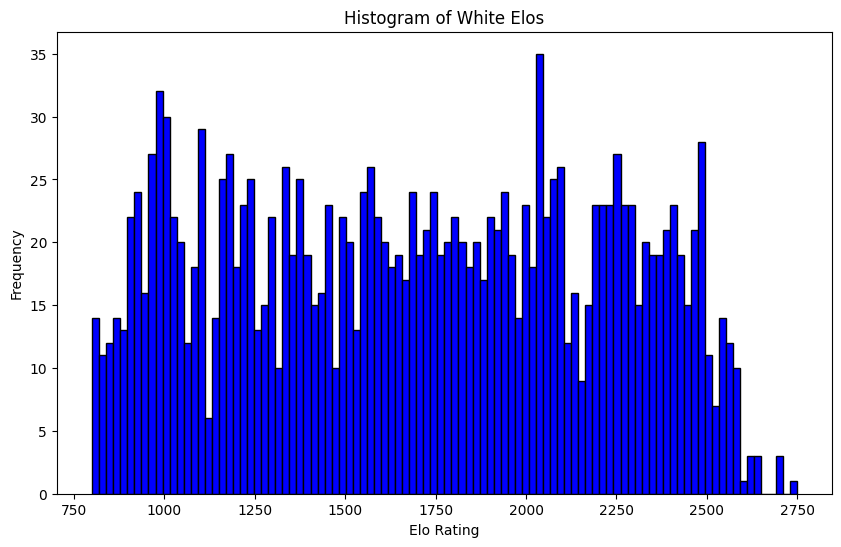

In [ ]:

plt.figure(figsize=(10, 6))
plt.hist(white_elos, bins=100, color='blue', edgecolor='black')
plt.title('Histogram of White Elos')
plt.xlabel('Elo Rating')
plt.ylabel('Frequency')
plt.show()

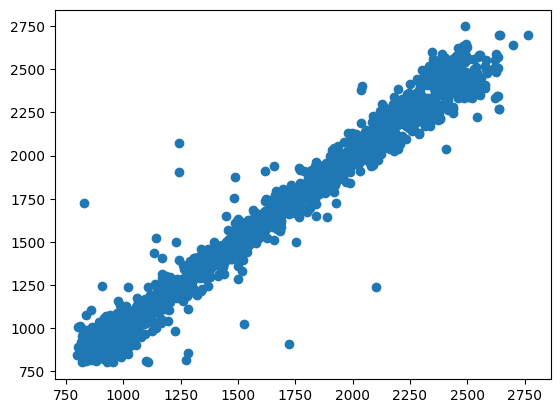

In [9]:
import matplotlib.pyplot as plt
plt.plot(black_elos, white_elos, 'o')

Filtered games count: 1759


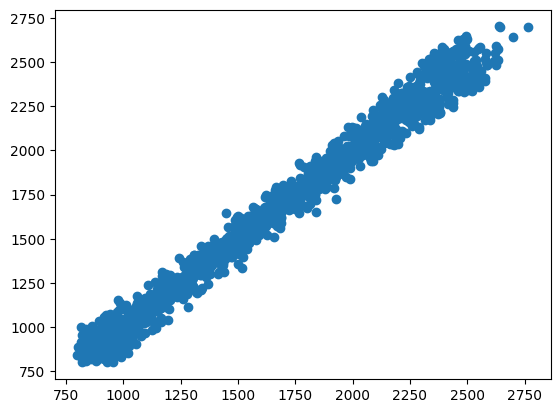

In [16]:
filtered_games = [game for game in games if abs(game[0] - game[1]) <= 200]
print(f"Filtered games count: {len(filtered_games)}")
plt.plot([game[1] for game in filtered_games], [game[0] for game in filtered_games], 'o')

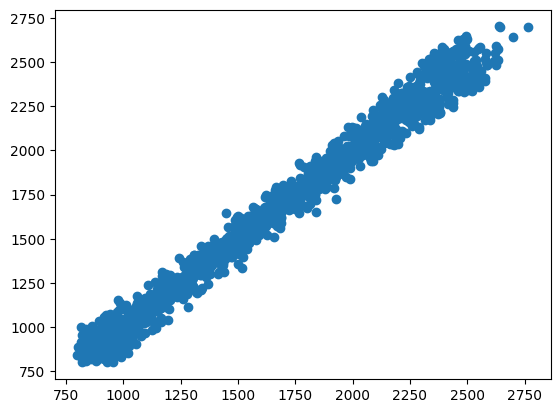

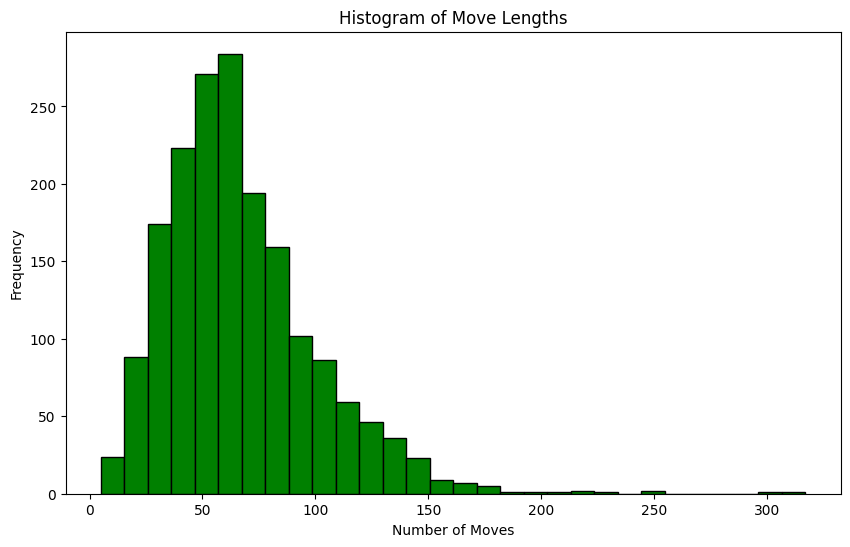

In [63]:
# Calculate the length of moves for each game
move_lengths = [len(game[3]) for game in games]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(move_lengths, bins=30, color='green', edgecolor='black')
plt.title('Histogram of Move Lengths')
plt.xlabel('Number of Moves')
plt.ylabel('Frequency')
plt.show()

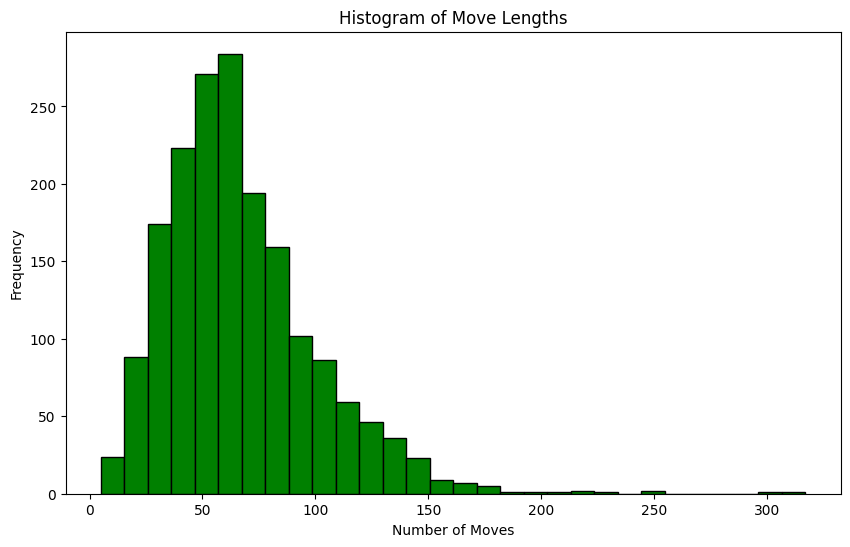

In [17]:
# Calculate the length of moves for each game
move_lengths = [len(game[3]) for game in games]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(move_lengths, bins=30, color='green', edgecolor='black')
plt.title('Histogram of Move Lengths')
plt.xlabel('Number of Moves')
plt.ylabel('Frequency')
plt.show()

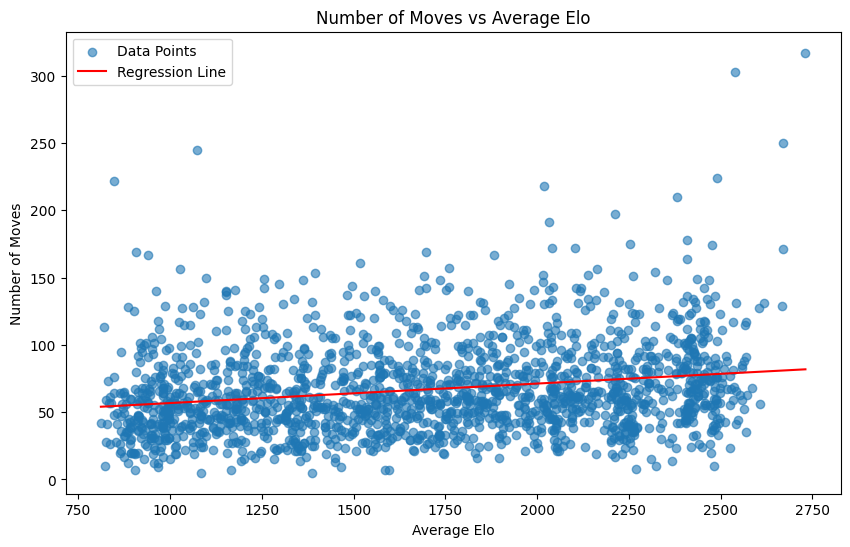

In [21]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Calculate average Elo for each game
# Calculate average Elo for each game
average_elos = [(game[0] + game[1]) / 2 for game in games]

# Plot number of moves vs average Elo
plt.figure(figsize=(10, 6))
plt.scatter(average_elos, move_lengths, alpha=0.6, label='Data Points')

# Fit a linear regression model
X = np.array(average_elos).reshape(-1, 1)
y = np.array(move_lengths)
model = LinearRegression()
model.fit(X, y)

# Plot the regression line
x_range = np.linspace(min(average_elos), max(average_elos), 100).reshape(-1, 1)
y_pred = model.predict(x_range)
plt.plot(x_range, y_pred, color='red', label='Regression Line')

plt.title('Number of Moves vs Average Elo')
plt.xlabel('Average Elo')
plt.ylabel('Number of Moves')
plt.legend()
plt.show()

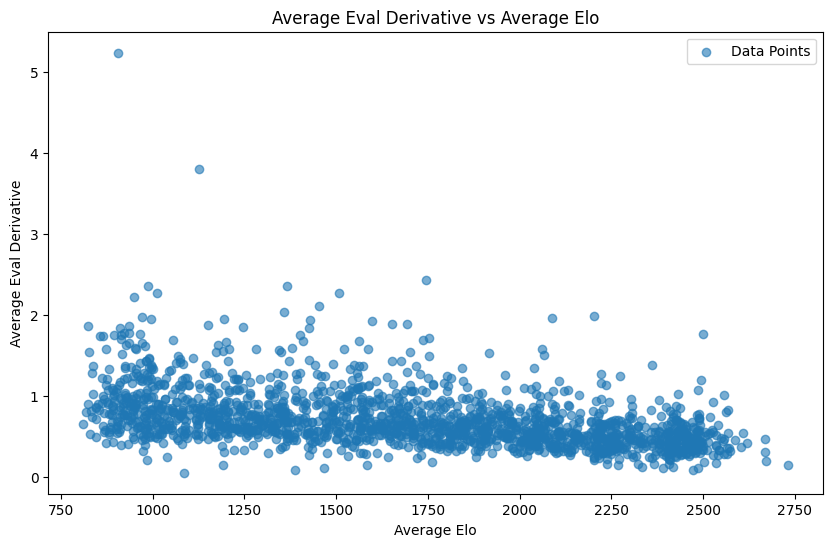

In [22]:
# Calculate average Elo and average eval derivative for each game
average_eval_derivatives = []
average_elos = []

for game in games:
    evals = game[4]
    if len(evals) > 1:
        # Calculate the derivative of evals
        eval_derivative = [abs(evals[i+1] - evals[i]) for i in range(len(evals) - 1)]
        average_eval_derivatives.append(sum(eval_derivative) / len(eval_derivative))
        # Calculate the average Elo
        average_elos.append((game[0] + game[1]) / 2)

# Plot average eval derivative vs average Elo
plt.figure(figsize=(10, 6))
plt.scatter(average_elos, average_eval_derivatives, alpha=0.6, label='Data Points')
plt.title('Average Eval Derivative vs Average Elo')
plt.xlabel('Average Elo')
plt.ylabel('Average Eval Derivative')
plt.legend()
plt.show()

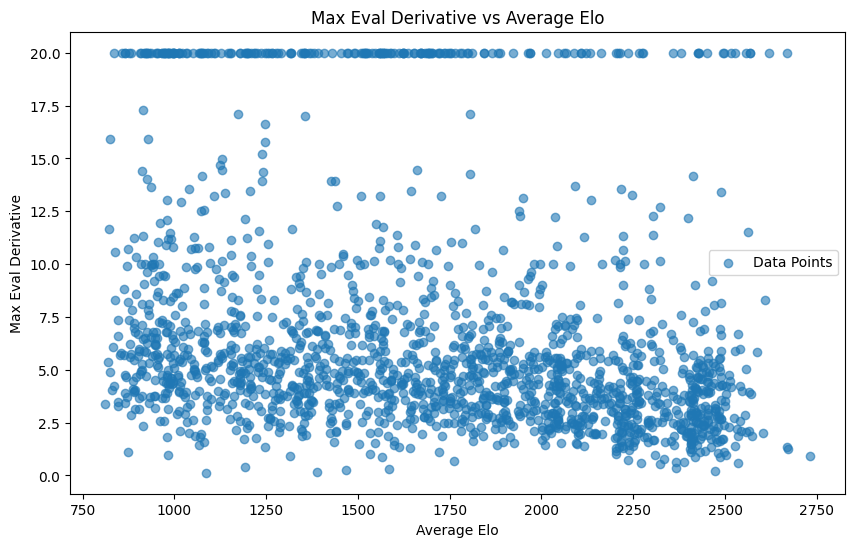

In [ ]:

average_eval_derivatives = []
average_elos = []

for game in games:
    evals = game[4]
    if len(evals) > 1:
        # Calculate the derivative of evals
        eval_derivative = [abs(evals[i+1] - evals[i]) for i in range(len(evals) - 1)]
        average_eval_derivatives.append(max(eval_derivative))
        # Calculate the average Elo
        average_elos.append((game[0] + game[1]) / 2)

# Plot average eval derivative vs average Elo
plt.figure(figsize=(10, 6))
plt.scatter(average_elos, average_eval_derivatives, alpha=0.6, label='Data Points')
plt.title('Max Eval Derivative vs Average Elo')
plt.xlabel('Average Elo')
plt.ylabel('Max Eval Derivative')
plt.legend()
plt.show()

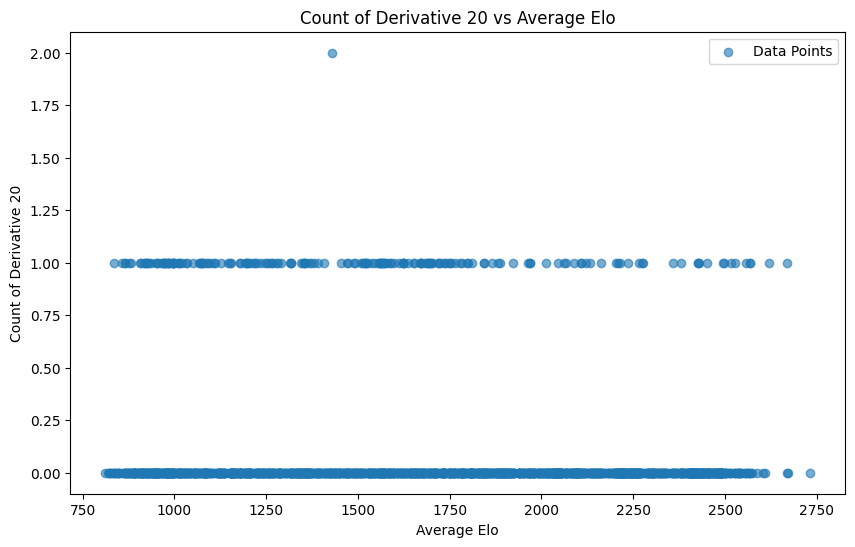

In [24]:
# Count the number of times the absolute derivative is 20 for each game
count_derivative_20 = []

for game in games:
    evals = game[4]
    if len(evals) > 1:
        # Calculate the derivative of evals
        eval_derivative = [abs(evals[i+1] - evals[i]) for i in range(len(evals) - 1)]
        count_derivative_20.append(eval_derivative.count(20))
    else:
        count_derivative_20.append(0)

# Plot the count of derivative 20 vs average Elo
plt.figure(figsize=(10, 6))
plt.scatter(average_elos, count_derivative_20, alpha=0.6, label='Data Points')
plt.title('Count of Derivative 20 vs Average Elo')
plt.xlabel('Average Elo')
plt.ylabel('Count of Derivative 20')
plt.legend()
plt.show()

Games with max abs eval derivative of 20 in each Elo bin:
800-999: 35
1000-1199: 28
1200-1399: 26
1400-1599: 29
1600-1799: 32
1800-1999: 11
2000-2199: 10
2200-2399: 9
2400-2599: 11


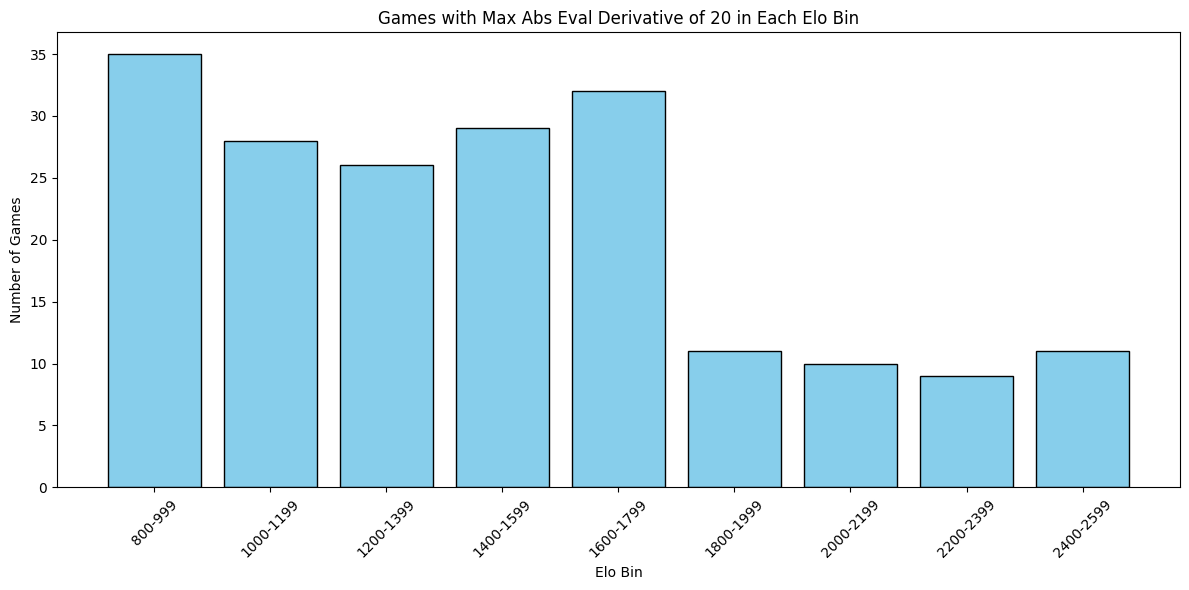

In [28]:
# Define Elo bins
elo_bins = range(800, 2800, 200)  # Bins from 800 to 1200 with a step of 50

# Initialize a dictionary to store the count of games with max abs eval derivative of 20 in each bin
games_with_max_derivative_20 = {f"{elo_bins[i]}-{elo_bins[i+1]-1}": 0 for i in range(len(elo_bins) - 1)}

# Iterate through the games and count
for avg_elo, max_derivative in zip(average_elos, average_eval_derivatives):
    for i in range(len(elo_bins) - 1):
        if elo_bins[i] <= avg_elo < elo_bins[i + 1]:
            if max_derivative == 20:
                games_with_max_derivative_20[f"{elo_bins[i]}-{elo_bins[i+1]-1}"] += 1
            break

# Print the results
print("Games with max abs eval derivative of 20 in each Elo bin:")
for bin_range, count in games_with_max_derivative_20.items():
    print(f"{bin_range}: {count}")

# Plot the results
plt.figure(figsize=(12, 6))
plt.bar(games_with_max_derivative_20.keys(), games_with_max_derivative_20.values(), color='skyblue', edgecolor='black')
plt.title('Games with Max Abs Eval Derivative of 20 in Each Elo Bin')
plt.xlabel('Elo Bin')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()